Predictive Analysis: What Drives Earnings?


In [1]:
# impprting the labraries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

1. Load the dataset

In [2]:
df = pd.read_excel("freelancer_earnings_bd.xlsx")   

print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
   Freelancer_ID       Job_Category       Platform Experience_Level  \
0              1    Web Development         Fiverr         Beginner   
1              2    App Development         Fiverr         Beginner   
2              3    Web Development         Fiverr         Beginner   
3              4         Data Entry  PeoplePerHour     Intermediate   
4              5  Digital Marketing         Upwork           Expert   

  Client_Region  Payment_Method  Job_Completed  Earnings_USD  Hourly_Rate  \
0          Asia  Mobile Banking            180          1620        95.79   
1     Australia  Mobile Banking            218          9078        86.38   
2            UK          Crypto             27          3455        85.17   
3          Asia   Bank Transfer             17          5577        14.37   
4          Asia          Crypto            245          5898        99.37   

   Job_Success_Rate  Client_Rating  Job_Duration_Days Project_Type  \
0          

In [10]:
# Create earning groups (adjust bins as needed)

max_earnings = df["Earnings_USD"].max()


df["Earn_Group"] = pd.cut(
    df["Earnings_USD"],
    
    bins=[-1, 3000, 6000, max_earnings],

    labels=["Low", "Medium", "High"]
).astype(str)


print(df["Earn_Group"].value_counts())


Earn_Group
High      785
Low       590
Medium    575
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Features & target
features = ["Platform","Job_Category","Experience_Level","Client_Region",
            "Hourly_Rate","Job_Success_Rate","Client_Rating","Marketing_Spend","Job_Duration_Days","Project_Type"]

X = df[features].copy()
y = df["Earn_Group"]

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# FIXED OneHotEncoder
preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

X_prep = preproc.fit_transform(X)

# Feature names
ohe = preproc.named_transformers_["cat"]
ohe_cols = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_cols + num_cols


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.25, random_state=42, stratify=y)

# Logistic Regression (multinomial)
logr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
logr.fit(X_train, y_train)
y_pred_log = logr.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


c:\Users\pc home\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.4077868852459016
              precision    recall  f1-score   support

        High       0.43      0.80      0.56       196
         Low       0.33      0.20      0.25       148
      Medium       0.39      0.10      0.16       144

    accuracy                           0.41       488
   macro avg       0.38      0.36      0.32       488
weighted avg       0.39      0.41      0.34       488

Decision Tree Accuracy: 0.3790983606557377
              precision    recall  f1-score   support

        High       0.40      0.72      0.51       196
         Low       0.33      0.23      0.27       148
      Medium       0.31      0.06      0.10       144

    accuracy                           0.38       488
   macro avg       0.35      0.34      0.30       488
weighted avg       0.35      0.38      0.32       488



c:\Users\pc home\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


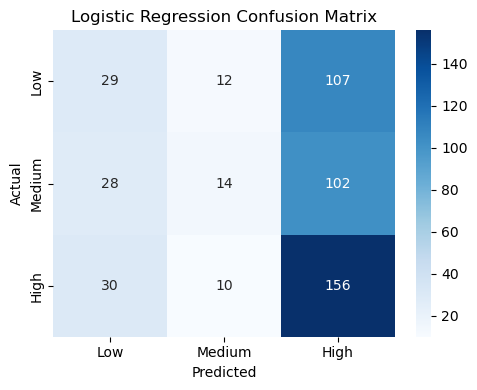

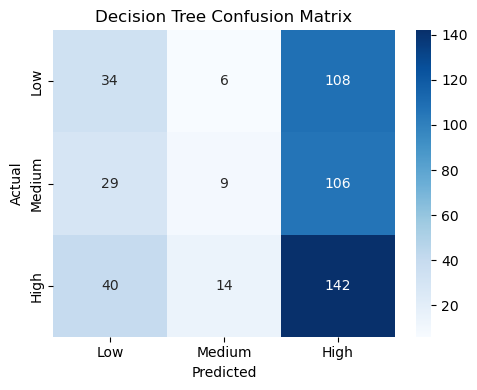

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# helper to plot & save
def plot_confusion(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=["Low","Medium","High"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Low","Medium","High"],
                yticklabels=["Low","Medium","High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

plot_confusion(y_test, y_pred_log, "Logistic Regression Confusion Matrix", "confusion_logr.png")
plot_confusion(y_test, y_pred_dt, "Decision Tree Confusion Matrix", "confusion_dt.png")


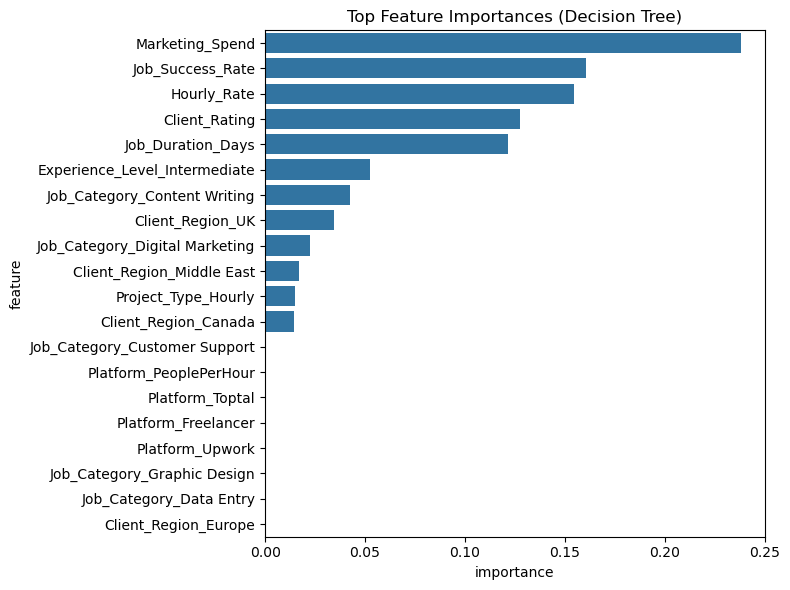

In [15]:
import numpy as np
# get importances
importances = dt.feature_importances_
# pair with feature names (only keep non-zero or top N)
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(20)

# plot
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Top Feature Importances (Decision Tree)")
plt.tight_layout()
plt.savefig("feature_importance_dt.png", dpi=150)
plt.show()


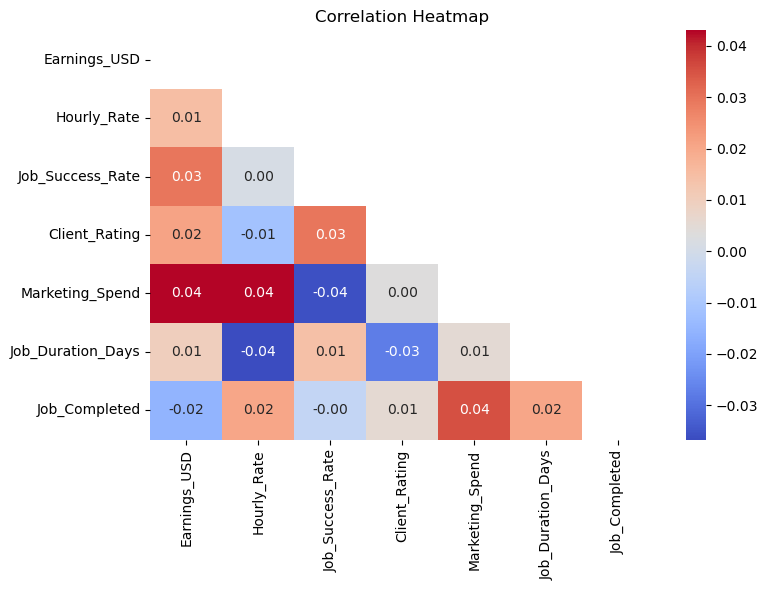

In [16]:
# numeric correlations
num_df = df[["Earnings_USD","Hourly_Rate","Job_Success_Rate","Client_Rating","Marketing_Spend","Job_Duration_Days","Job_Completed"]].dropna()
corr = num_df.corr()

plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=150)
plt.show()
